In [11]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.modeling.models import BlackBody
from astropy.time import Time
from astropy import units as u
from astropy import constants as c
from astropy.io import fits
import matplotlib.gridspec as gridspec

from matplotlib import colormaps
import pickle

In [12]:
def apply_highpass_filter(data, freq_cutoff, **kwargs):
    """Return high pass filtered data."""
    filter_order = kwargs.pop('N', 6)
    b, a = signal.butter(N=filter_order, Wn=freq_cutoff, btype='highpass', output='ba', fs=1, **kwargs)
    
    # when applying to the synthetic template
    if data.ndim == 1:
        data_f = signal.filtfilt(b, a, data)
        
    # when applying to the spectral time series data
    elif data.ndim == 2:
        data_f = np.zeros(data.shape)
        for n in range(data.shape[0]):
            data_f[n,:] = signal.filtfilt(b, a, data[n,:])
    
    else:
        raise ValueError('Array has too many dimensions.')
    
    return data_f


def calc_orbital_phase(t, t0, period, phase0=0.):
    return ((t-t0)/period+phase0) % 1

def apply_rv(wav, rv):
    """Apply a radial velocity shift to the spectrum."""
    c = 3.0e8 # m/s
    wav_shifted = wav * np.sqrt((1+rv/c)/(1-rv/c))
    return wav_shifted

def regrid_spectrum(wav, spec, wav_new):
    """Regrid spectrum to new wavelength grid."""
    return wav_new, np.interp(x=wav_new, xp=wav, fp=spec)

def estimate_kp(semimajor, mstar, inclination):
    return np.sqrt((G.value*mstar)/semimajor) * np.sin(inclination)

def get_rvplanet(vbary, vsys, kp, phase):
    """Phase expected in between 0 and 1 as it's converted to radians."""
    return vbary + vsys + kp*np.sin(phase*2*np.pi)

def shift_to_new_restframe(ccmatrix, rv0, rvshift):
    ccmatrix_shifted = np.zeros(ccmatrix.shape)
    for i in range(ccmatrix.shape[0]):
        ccmatrix_shifted[i,:] = np.interp(x=rv0+rvshift[i], xp=rv0, fp=ccmatrix[i, :], left=np.nan, right=np.nan)
    return ccmatrix_shifted

def calc_ccmatrix(data, data_wav, template_wav, template_spec,
                  rv_sample, mask=None, wav_pad=0.1, apply_hpf=False, hpf_fc=None):
    
    if mask is None:
        mask = np.zeros(data.shape)
    MASK = ~np.any(mask, axis=0)
    #MASK = ~np.all(mask, axis=0) 
    
    if apply_hpf:
        from .cleanspec import apply_highpass_filter
    
    # wav_pad needs to be larger than maximal RV induced wavelength shift
    wavrange = np.logical_and(template_wav >= data_wav[0] - wav_pad,
                              template_wav <= data_wav[-1] + wav_pad)

    nshifts = len(rv_sample)
    nobs = int(data.shape[0])
    ccmatrix = np.zeros(shape=(nobs, nshifts))
    for i in range(nobs):
        data_spec = data[i,:]
        for j, rv in enumerate(rv_sample):
            template_wav_shifted = apply_rv(template_wav[wavrange], rv)
            template_wav_regridded, template_spec_regridded = regrid_spectrum(template_wav_shifted,
                                                                              template_spec[wavrange],
                                                                              data_wav)
            
            # apply high pass filter to model as well
            if apply_hpf:
                yoffset = np.median(template_spec_regridded)
                template_spec_regridded = apply_highpass_filter(template_spec_regridded, freq_cutoff=hpf_fc) + yoffset

            ccmatrix[i, j] = np.corrcoef(template_spec_regridded[MASK], data_spec[MASK])[0, 1] #Pearson
    return ccmatrix

def calc_ccmatrix_2d(data, data_wav, template_wav, template_data,
                     rv_sample, mask=None, wav_pad=0.1, apply_hpf=False, hpf_fc=None):

    if mask is None:
        mask = np.zeros(data.shape)
    MASK = ~np.all(mask, axis=0)
    
    nshifts = len(rv_sample)
    nobs = int(data.shape[0])
    ccmatrix = np.zeros(shape=(nobs, nshifts))
    for i in range(nobs):
        data_spec = data[i,:]
        for j, rv in enumerate(rv_sample):
            template_wav_shifted = apply_rv(template_wav, rv)
            template_wav_regridded, template_spec_regridded = regrid_spectrum(template_wav_shifted,
                                                                              template_data[:,i],
                                                                              data_wav)
            
            # apply high pass filter to model as well
            if apply_hpf:
                yoffset = np.median(template_spec_regridded)
                template_spec_regridded = apply_highpass_filter(template_spec_regridded, freq_cutoff=hpf_fc) + yoffset

            ccmatrix[i, j] = np.corrcoef(template_spec_regridded[MASK], data[i,:][MASK])[0, 1] #Pearson
    return ccmatrix

def fast_calc_ccmatrix(data, data_wav, template_wav,
                       template_data, rv_sample, mask):
    """"""
    mask = ~np.any(mask, axis=0) # Convert to a boolean mask
    ccmatrix = np.zeros(shape=(data.shape[0], len(rv_sample)))
    for i in range(nobs):
        for j, rv in enumerate(rv_sample):
            template_wav_regridded, template_spec_regridded = regrid_spectrum(apply_rv(template_wav, rv),
                                                                              template_data[:,i],
                                                                              data_wav)
            ccmatrix[i, j] = np.corrcoef(template_spec_regridded[MASK], data[i,:][mask])[0, 1]
    return ccmatrix

def plot_ccmatrices(ccmatrices, ccmatrix_avg, ccmatrix_weighted_avg, orders, rv_sample):
    """Plot cross-correlation matrices for all orders and their combined average."""
    rv_min = rv_sample[0]
    rv_max = rv_sample[-1]
    deltav = rv_sample[1] - rv_sample[0]
    
    plt.figure(figsize=(10, 10))
    norders = len(orders)
    gs = gridspec.GridSpec(norders+2, 1, hspace=0.)
    axes = [plt.subplot(gs[n,0]) for n in range(norders+2)]

    vmin = np.min(ccmatrices)
    vmax = np.max(ccmatrices)

    axes[0].set_title('Overview of cross-correlation matrices for all orders', size=15)
    # axes[np.floor((norders+1)/2.).astype(int)].set_ylabel('Frame number', size=15)
    for i in range(norders):
        axes[i].imshow(ccmatrices[i], extent=[0,1,0,1], aspect='auto', vmin=vmin, vmax=vmax, cmap='Greys_r', origin='lower')
        axes[i].annotate('Order = {}'.format(orders[i]), xy=(0.01,0.7), xycoords='axes fraction', va='bottom', ha='left', color='w', fontsize=12)
        axes[i].set_yticks([])
        axes[i].set_xticks([])

    axes[-2].imshow(ccmatrix_avg, vmin=vmin, vmax=vmax,
                    extent=[(rv_min-deltav/2.)/1e3,(rv_max+deltav/2.)/1e3,0,1], aspect='auto', cmap='Greys_r', origin='lower')
    axes[-2].annotate('Average (uniform weights)'.format(orders[i]), xy=(0.01,0.7), xycoords='axes fraction',
                      va='bottom', ha='left', color='w', fontsize=12)
    axes[-2].set_yticks([])
    axes[-2].set_xticks([])
    
    axes[-1].imshow(ccmatrix_weighted_avg, vmin=vmin, vmax=vmax, extent=[(rv_min-deltav/2.)/1e3,(rv_max+deltav/2.)/1e3,0,1], aspect='auto', cmap='Greys_r', origin='lower')
    axes[-1].annotate('Average (non-uniform weights)'.format(orders[i]), xy=(0.01,0.7), xycoords='axes fraction', va='bottom', ha='left', color='w', fontsize=12)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel(r'$\rm{\Delta v}$ (km/s)', size=15)
    return axes

def get_trails(ccmatrix, trail_width, radius):
    """Get in and out of trail samples from the cross correlation matrix."""
    cx, cy = np.array(ccmatrix.shape, float)/2.

    IN_TRAIL = slice(int(cy-np.floor(trail_width/2.)), int(cy+np.ceil(trail_width/2.)), 1)
    LEFTSIDE_OUT_OF_TRAIL = slice(None, int(cy-radius), 1)
    RIGHTSIDE_OUT_OF_TRAIL = slice(int(cy+radius), None, 1)
    
    in_trail_sample = ccmatrix[:,IN_TRAIL].flatten()
    out_of_trail_sample = np.concatenate([ccmatrix[:,LEFTSIDE_OUT_OF_TRAIL].flatten(),
                                          ccmatrix[:,RIGHTSIDE_OUT_OF_TRAIL].flatten()])
    return in_trail_sample, out_of_trail_sample

def p_to_sigmas(pval):
    nd = stats.norm(0., 1.)
    # We use the 'inverse survival function', the inverse of the sf. We also need to divide
    # our p-value by 2 to account for the negative side of the normal distribution.
    return nd.isf((pval)/2.)

def ttest_on_trails(ccmatrix, trail_width, radius, plot=True):
    """Perform a T-test to get a detection significance between in and out of trail samples."""
    in_trail_sample, out_of_trail_sample = get_trails(ccmatrix, trail_width, radius)

    tvalue, pvalue = stats.ttest_ind(in_trail_sample[~np.isnan(in_trail_sample)], out_of_trail_sample[~np.isnan(out_of_trail_sample)],  equal_var=False) # equal var = False: performs Welch's T-Test
    sigma_detection = np.sign(tvalue) * p_to_sigmas(pvalue)#stats.norm.ppf(1-pvalue/2., loc=0, scale=1)
    
    if plot:
        fig = plt.figure(figsize=(5*1.68,5))
        bins = np.linspace(-0.1,0.1,15)
        plt.title('T-test result (sigma={:.2f})'.format(sigma_detection))
        plt.hist(in_trail_sample, bins, density=True, label='in trail', color=TABLEAU20[6], alpha=0.5, histtype='step')
        plt.hist(out_of_trail_sample, bins, density=True, label='out of trail', color='k', alpha=0.5, histtype='step')
        plt.xlabel('CCF value', size=15)
        plt.ylabel('Probability density', size=15)
        plt.legend(fontsize=12)
        
    return sigma_detection

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_simple_snr(ccmatrix, radius=0, return_signal=False):
    """Get SNR in a simple way between the in trail and out of trail sample."""
    ccmatrix_collapsed = np.sum(ccmatrix, axis=0)
    center = int(np.floor(float(len(ccmatrix_collapsed))/2.))
    signal = ccmatrix_collapsed[center]
    noise = np.nanstd(np.concatenate([ccmatrix_collapsed[:center-radius], ccmatrix_collapsed[center+radius:]]))
    snr = signal/noise
    if not return_signal:
        return snr
    else:
        return signal

def calc_detection_matrices(ccmatrix, trial_vsys, trial_kp, phase, rv_sample, vbary, vsys, radius=5, trail_width=1):
    sigmamatrix = np.zeros(shape=(len(trial_vsys), len(trial_kp)))
    snrmatrix = np.zeros(shape=(len(trial_vsys), len(trial_kp)))
    
    try:
        from tqdm.notebook import tqdm
    except:
        from tqdm import tqdm

    with tqdm(total=len(trial_kp)*len(trial_vsys)) as pbar:
        for i, vsys_t in enumerate(trial_vsys):
            for j, kp_t in enumerate(trial_kp):
                rvtrial = -vbary + vsys + vsys_t + kp_t*np.sin(phase*2*np.pi) # rv trial, shifted to the planet's rest frame
                ccmatrix_shifted = shift_to_new_restframe(ccmatrix, rv0=rv_sample, rvshift=rvtrial)
                
                snrmatrix[i,j] = get_simple_snr(ccmatrix_shifted, radius=radius)
                sigmamatrix[i,j] = ttest_on_trails(ccmatrix_shifted, trail_width=trail_width, radius=radius, plot=False)

                pbar.update()            
    return snrmatrix, sigmamatrix

def calc_detection_matrices(ccmatrix, trial_vsys, trial_kp, phase, rv_sample, vbary, vsys, radius=5, trail_width=1):
    sigmamatrix = np.zeros(shape=(len(trial_vsys), len(trial_kp)))
    snrmatrix = np.zeros(shape=(len(trial_vsys), len(trial_kp)))
    
    try:
        from tqdm.notebook import tqdm
    except:
        from tqdm import tqdm

    with tqdm(total=len(trial_kp)*len(trial_vsys)) as pbar:
        for i, vsys_t in enumerate(trial_vsys):
            for j, kp_t in enumerate(trial_kp):
                rvtrial = -vbary + vsys + vsys_t + kp_t*np.sin(phase*2*np.pi) # rv trial, shifted to the planet's rest frame
                ccmatrix_shifted = shift_to_new_restframe(ccmatrix, rv0=rv_sample, rvshift=rvtrial)
                
                snrmatrix[i,j] = get_simple_snr(ccmatrix_shifted, radius=radius)
                sigmamatrix[i,j] = get_simple_snr(ccmatrix_shifted, radius=radius, return_signal=True) #ttest_on_trails(ccmatrix_shifted, trail_width=trail_width, radius=radius, plot=False)

                pbar.update()            
    return snrmatrix, sigmamatrix

def calc_detection_matrices_wr(ccmatrix, dvsys_all, dkp_all, phase, rv_sample, vbary, vsys, kp, radius=5, trail_width=1):
    sigmamatrix = np.zeros(shape=(len(dvsys_all), len(dkp_all)))
    snrmatrix = np.zeros(shape=(len(dvsys_all), len(dkp_all)))
    
    try:
        from tqdm.notebook import tqdm
    except:
        from tqdm import tqdm
    
    with tqdm(total=len(dkp_all)*len(dvsys_all)) as pbar:
        for i, dvsys in enumerate(dvsys_all):
            for j, dkp in enumerate(dkp_all):
                rvtrial = get_rvplanet(-vbary, vsys+dvsys, kp+dkp, phase)
                ccmatrix_shifted = shift_to_new_restframe(ccmatrix, rv0=rv_sample, rvshift=rvtrial)
                snrmatrix[i,j] = get_simple_snr(ccmatrix_shifted, radius=radius)
                sigmamatrix[i,j] = ttest_on_trails(ccmatrix_shifted, trail_width=trail_width, radius=radius, plot=False)

                pbar.update()            
    return snrmatrix, sigmamatrix

def calc_rv_planet(vbary, vsys, kp, phase):
    return vbary + vsys + kp*np.sin(phase*2*np.pi)

def get_planet_params(data, trial_kp, trial_vsys):
    yy, xx = np.meshgrid(trial_kp, trial_vsys)
    indmax = np.unravel_index(data.argmax(), data.shape)
    vsys_max, kp_max = xx[indmax], yy[indmax]
    value_max = data[indmax]
    return vsys_max, kp_max, value_max

def locate_2d_max(img, x, y):
    yy, xx = np.meshgrid(y, x)
    imax = np.unravel_index(img.argmax(), img.shape)
    ymax, xmax = xx[imax], yy[imax]
    valuemax = data[imax]
    return xmax, ymax, valuemax

# def plot_detection_matrix(data, trial_kp, trial_vsys, kp_vsys_expected=None, cmap='Reds_r', cmap_step=1,
#                           unit='SNR', title='', interp_method=None):
#     sf=7.5
#     fig = plt.figure(figsize=(sf, sf))

#     gs = gridspec.GridSpec(1, 2, width_ratios=[1,0.05], wspace=0.025)
#     ax = plt.subplot(gs[0,0])
#     cax = plt.subplot(gs[0,1])

#     # Create a discrete colormap
#     cmap = plt.cm.get_cmap(cmap)
#     bounds = np.arange(np.floor(data.min()), np.ceil(data.max())+cmap_step, cmap_step)
#     norm = colors.BoundaryNorm(bounds, cmap.N)
    
#     dvsys = trial_vsys[1]-trial_vsys[0]
#     dkp = trial_kp[1]-trial_kp[0]
#     extent=[(trial_vsys[0]-dvsys/2.)/1e3, (trial_vsys[-1]+dvsys/2.)/1e3,
#                            (trial_kp[0]-dkp/2.)/1e3, (trial_kp[-1]+dkp/2.)/1e3]
    
#     im = ax.imshow(data.T, origin='lower',
#                    extent=extent,
#                    aspect='auto', cmap=cmap, norm=norm, interpolation=interp_method)
#     ax.tick_params(labelsize=12)
#     ax.set_xlabel(r'Planet rest frame (km/s)', size=15)
#     ax.set_ylabel(r'$\rm{K}_{\rm{p}}$ (km/s)', size=15)

#     # Plot dotted lines to the planet's estimate (vsys, kp)
#     vsys_max, kp_max, snr_max = get_planet_params(data, trial_kp, trial_vsys)

#     ax.plot([vsys_max/1e3, vsys_max/1e3], [extent[2], kp_max/1e3], ls='--', color='w', lw=0.75)
#     ax.plot([extent[0], vsys_max/1e3], [kp_max/1e3, kp_max/1e3], ls='--', color='w', lw=0.75)

#     # add text with highest SNR
#     ax.annotate('{} detection = {:.1f}\n'.format(unit, snr_max)+
#                 r'$\rm{\Delta v}_{\rm{sys}}$'+'= {:.1f} km/s\n'.format(vsys_max/1e3)+
#                 r'$\rm{K}_{\rm{p}}$'+'= {:.1f} km/s'.format(kp_max/1e3),
#                 (0.05, 0.95), xycoords='axes fraction', va='top', size=12, color='w')

#     cbar = plt.colorbar(mappable=im, cax=cax)
#     cbar.set_label('{}'.format(unit), size=15)
#     cax.tick_params(labelsize=12)

#     ax.set_title(title, size=12)

#     return ax, cax, cbar

def plot_detection_matrix(data, dkp_all, dvsys_all, kp, vsys,
                          mode='snr', title='', interp_method='bicubic', **kwargs):
    
    extend='neither'
    if mode == 'snr':
        quantity = 'SNR'
        cmap = 'Reds_r'
        ncolors=10
        markercolor = 'gray'
    elif mode == 'ttest':
        quantity = '$\sigma$'
        cmap = 'Reds_r'
        ncolors=10
        markercolor = 'gray'
    elif mode == 'loglike':
        quantity = 'log L'
        cmap = 'Blues_r'
        ncolors=10
        markercolor = 'gray'
    elif mode == 'dloglike':
        quantity = r'2 $\Delta$ log L'
        cmap = 'Blues_r'
        ncolors=10
        markercolor = 'gray'
    elif mode == 'wilks':
        quantity = '$\sigma$'
        cmap = 'viridis'
        markercolor = 'w'
    elif mode == 'wilks2':
        quantity = '$\sigma$'
        cmap = 'viridis_r'
        markercolor = 'w'
    else:
        raise ValueError("Unknown mode: {}."
                         "Supported modes are: 'snr', 'ttest', 'wilks' or 'loglike'")
        
    if mode in ('snr', 'ttest', 'loglike', 'dloglike'):
        cmap = plt.cm.get_cmap(cmap)
        try:
            bounds = np.round(np.linspace(data.min(), data.max(), 10), 1)
            norm = colors.BoundaryNorm(bounds, cmap.N)
        except:
            bounds = np.round(np.linspace(data.min(), data.max(), 10), 1)
            norm = colors.BoundaryNorm(bounds, cmap.N)
    elif mode == 'wilks':
        sigma_min = kwargs.pop('sigma_min', 1)
        cmap = plt.cm.get_cmap(cmap)
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmaplist[0] = (.5, .5, .5, 1.0)
        cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
        bounds = np.arange(sigma_min-1, np.ceil(data.max())+1, 1)
        bounds[0] = 0
        bounds[1] = sigma_min
        norm = colors.BoundaryNorm(bounds, cmap.N)
    elif mode == 'wilks2':
        cmap = plt.cm.get_cmap(cmap)
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
        sigma_max = kwargs.pop('sigma_max', np.ceil(data.max()))
        if sigma_max < np.ceil(data.max()):
            extend = 'max'
        bounds = np.arange(0, sigma_max+1, 1)
        norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Create figure and axes
    sf=10
    fig = plt.figure(figsize=(1.25*sf, sf))
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.95,0.035], wspace=0.025)
    ax = plt.subplot(gs[0,0])
    cax = plt.subplot(gs[0,1])

    # Set appropriate ranges
    dvsys = dvsys_all[1]-dvsys_all[0]
    dkp = dkp_all[1]-dkp_all[0]
    extent=[
        (dvsys_all[0]-dvsys/2.+vsys)/1e3,
        (dvsys_all[-1]+dvsys/2.+vsys)/1e3,
        (dkp_all[0]-dkp/2.+kp)/1e3,
        (dkp_all[-1]+dkp/2.+kp)/1e3
    ]
    
    # Plot matrix
    im = ax.imshow(data.T, origin='lower',
                   extent=extent,
                   aspect='auto', cmap=cmap,
                   norm=norm, interpolation=interp_method)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(r'System velocity (km/s)', size=15)
    ax.set_ylabel(r'$\rm{K}_{\rm{p}}$ (km/s)', size=15)
    
    # Plot dotted lines to the planet's estimate (vsys, kp)
    if mode != 'wilks2':
        vsys_max, kp_max, value_max = get_planet_params(data, kp+dkp_all, vsys+dvsys_all)
    else:
        vsys_max, kp_max, value_max = get_planet_params(-data, kp+dkp_all, vsys+dvsys_all) # find min instead of max in this mode
    
    ax.plot([vsys/1e3, vsys/1e3], [extent[2], extent[3]], ls='--', color='w', lw=2)
    ax.plot([extent[0], extent[1]], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.scatter( (vsys_max)/1e3, (kp_max)/1e3, marker="+", s=300, facecolors=markercolor, lw=3)
    
    # Add text with highest SNR
    if mode != 'wilks2':
        ax.annotate('{} detection = {:.1f}\n'.format(quantity, value_max)+
                    r'$\rm{v}_{\rm{sys}}$'+'= {:.1f} km/s\n'.format(vsys_max/1e3)+
                    r'$\rm{K}_{\rm{p}}$'+'= {:.1f} km/s'.format(kp_max/1e3),
                    (0.05, 0.95), xycoords='axes fraction', va='top', size=15, color='w')
    else:
        ax.annotate(r'$\rm{v}_{\rm{sys}}$'+'= {:.1f} km/s\n'.format(vsys_max/1e3)+
                    r'$\rm{K}_{\rm{p}}$'+'= {:.1f} km/s'.format(kp_max/1e3),
                    (0.05, 0.95), xycoords='axes fraction', va='top', size=15, color='w')
    
    # Plot colorbar
    cbar = plt.colorbar(mappable=im, cax=cax,extend=extend)
    cbar.set_label('{}'.format(quantity), size=15)
    cax.tick_params(labelsize=12)
    
    # Set title
    ax.set_title(title, size=17)
    return ax, cax, cbar

def plot_ccmatrix(ccmatrix, ccmatrix_shifted, rv_sample, phase, cmap='Greys_r', pad=0.01, **kwargs):
    """Create an overview plot of cross-correlation matrix in the planet and observer's rest frame."""
    rv_min = rv_sample[0]
    rv_max = rv_sample[-1]
    deltav = rv_sample[1] - rv_sample[0]
    
    ccmatrix_collapsed = np.mean(ccmatrix, axis=0)
    ccmatrix_shifted_collapsed = np.mean(ccmatrix_shifted, axis=0)
    
    sf=3
    fig = plt.figure(figsize=(3*sf, 2*sf))
    gs = gridspec.GridSpec(2,3,
                           height_ratios = [1.68, 1], width_ratios=[1.68,1,0.05],
                           hspace=0.0, wspace=0.05)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[1,0])
    ax3 = plt.subplot(gs[0,1])
    ax4 = plt.subplot(gs[1,1])
    ax5 = plt.subplot(gs[:,2])
    axes = (ax1, ax2, ax3, ax4, ax5)

    CCMIN = kwargs.pop("ccmin", min(np.nanmin(ccmatrix), np.nanmin(ccmatrix_shifted)))
    CCMAX = kwargs.pop("ccmax", max(np.nanmax(ccmatrix), np.nanmax(ccmatrix_shifted)))
    CCCMIN = min([np.nanmin(ccmatrix_collapsed), np.nanmin(ccmatrix_shifted_collapsed)]) - pad
    CCCMAX = max([np.nanmax(ccmatrix_collapsed), np.nanmax(ccmatrix_shifted_collapsed)]) + pad

    extent = [rv_min/1e3, rv_max/1e3, phase[0], phase[-1]]
    im = ax1.imshow(ccmatrix, origin='lower', extent=extent, aspect='auto', cmap=cmap, vmin=CCMIN, vmax=CCMAX)
    ax1.set_xticks([])
    nyticks = 5
    ax1.set_yticks(np.linspace(phase[0], phase[-1], nyticks+2)[1:])
    ax1.set_yticklabels([ "{:.2f}".format(phase) for phase in np.linspace(phase[0], phase[-1], nyticks+2)[1:]])
    ax1.tick_params(labelsize=12)
    ax1.set_ylabel('Phase', size=15)
    ax1.set_title("Observer's rest frame", size=15)
    ax1.set_xlim((1./2.)*rv_min/1e3, (1./2.)*rv_max/1e3)

    ax2.plot(rv_sample/1e3, ccmatrix_collapsed, color='k', lw=1)
    ax2.tick_params(labelsize=12)
    ax2.set_xlabel(r'v (km/s)', size=15)
    ax2.set_ylabel('Mean CC', size=15)
    yticks = np.arange(np.round(CCCMIN,1), CCCMAX, 0.01)
    ax2.set_yticks(yticks)
    ax2.set_ylim(CCCMIN,CCCMAX)
    ax2.set_xlim((1./2.)*rv_min/1e3, (1./2.)*rv_max/1e3)

    ax3.imshow(ccmatrix_shifted, origin='lower', extent=extent, aspect='auto', cmap=cmap, vmin=CCMIN, vmax=CCMAX)
    ax3.set_xticks([])
    nyticks = 5
    ax3.set_yticks([])
    ax3.tick_params(labelsize=12)
    ax3.set_xlim((1./4.)*rv_min/1e3, (1./4.)*rv_max/1e3)
    ax3.set_title("Planet's rest frame", size=15)

    ax4.plot(rv_sample/1e3, ccmatrix_shifted_collapsed, color='k', lw=1)
    ax4.tick_params(labelsize=12)
    ax4.set_yticks([])
    ax4.set_ylim(CCCMIN,CCCMAX)
    ax4.set_xticks(np.linspace(0.5*rv_min/1e3, 0.5*rv_max/1e3, 5)[1:-1])
    ax4.set_xlim((1./4.)*rv_min/1e3, (1./4.)*rv_max/1e3)
    ax4.set_xlabel('v (km/s)', size=15)

    cbar = plt.colorbar(mappable=im, cax=ax5)
    cbar.ax.tick_params(labelsize=12)
    return axes, cbar

In [13]:
APJ_SINGLE_COL = 3.5
APJ_DOUBLE_COL = 7.
TEXTSIZE=12

WR_RED = '#80273F'
WR_GREEN = '#008000'

In [14]:
dirin_xcor = '../data/xcor_out/WASP-189_2024A_2024_04_19/W189b_pRT_1D_Yan22_chem_eq_all/NPC_7_mp_70'
rv_sample = np.load(os.path.join(dirin_xcor, 'rv_sample.npy'))

dirin_xcor = '../data/xcor_out/WASP-189_2023A_2023_06_09_2024A_2024_04_19/W189b_pRT_1D_Yan22_chem_eq_all/NPC_7_mp_70_ccw'
ccmatrix = fits.getdata(os.path.join(dirin_xcor, 'ccmatrix.fits'))
ph_arr = np.load(os.path.join(dirin_xcor, 'ph_arr.npy'))
ph_mask = np.load(os.path.join(dirin_xcor, 'ph_mask.npy'))
vbary_arr = np.load(os.path.join(dirin_xcor, 'vbary.npy'))       

planet = {
    'Tdur' : 4.3336 * u.h,
    'P' : 2.7240308 * u.d
}

phase_eclipse_start = 0.5 - (planet['Tdur']/planet['P']).to(u.dimensionless_unscaled).value * 0.5
phase_eclipse_end = 0.5 + (planet['Tdur']/planet['P']).to(u.dimensionless_unscaled).value * 0.5
ph_mask_pre = (ph_arr < phase_eclipse_start)
ph_mask_post = (ph_arr > phase_eclipse_end)

vsys = -24.452e3 * (u.m/u.s) # ?+23
vsys = -20.82e3* (u.m/u.s) # Yan+22 from HARPS spectra
kp = 197e3 * (u.m/u.s) # ?+23

trial_kp, trial_vsys, snrmatrix = pickle.load(open(
    f'../data/xcor_out/WASP-189_2023A_2023_06_09_2024A_2024_04_19/W189b_pRT_1D_Yan22_chem_eq_all/NPC_7_mp_70_ccw/snrmap.pkl', 'rb'))
delta_vsys_max, kp_max, snr_max = get_planet_params(
    snrmatrix,
    trial_kp,
    trial_vsys
)

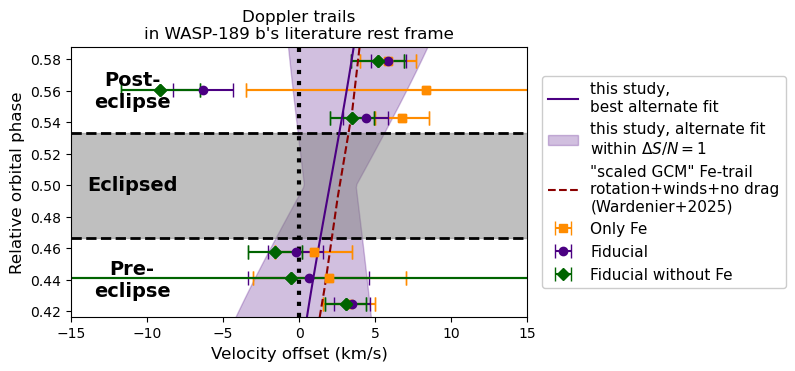

In [15]:
fig, ax = plt.subplots(figsize=(APJ_SINGLE_COL*1.68, APJ_SINGLE_COL*1.))

rv_data = pickle.load(open('../data/doppler_trails/Fe_trail.pkl', 'rb'))
for d, label, color in zip(rv_data, ('Only Fe', 'None'), ('darkorange', 'darkorange')):
    x, y, xerr = d
    plt.errorbar(x, y, xerr=xerr, fmt='s', capsize=5, color=color)
    if label == 'None':
        plt.errorbar(x, y, xerr=xerr, fmt='s', capsize=5, color=color)
    else:
        plt.errorbar(x, y, xerr=xerr, fmt='s', capsize=5, color=color, label=label)

rv_data = pickle.load(open('../data/doppler_trails/Fiducial_trail.pkl', 'rb'))
for d, label, color in zip(rv_data, ('Fiducial', 'None'), ('indigo', 'indigo')):
    x, y, xerr = d
    if label == 'None':
        plt.errorbar(x, y, xerr=xerr, fmt='o', capsize=5, color=color)
    else:
        plt.errorbar(x, y, xerr=xerr, fmt='o', capsize=5, color=color, label=label)
        
rv_data = pickle.load(open('../data/doppler_trails/Fiducial_without_Fe_trail.pkl', 'rb'))
for d, label, color in zip(rv_data, ('Fiducial without Fe', 'None'), ('darkgreen', 'darkgreen')):
    x, y, xerr = d
    plt.errorbar(x, y, xerr=xerr, fmt='D', capsize=5, color=color)
    if label == 'None':
        plt.errorbar(x, y, xerr=xerr, fmt='D', capsize=5, color=color)
    else:
        plt.errorbar(x, y, xerr=xerr, fmt='D', capsize=5, color=color, label=label)

plt.axhline(phase_eclipse_end, color='k', ls='--', lw=2)
plt.axhline(phase_eclipse_start, color='k', ls='--', lw=2)
# plt.annotate('Post-\neclipse', xy=(-11, 0.56), color='k', size=14,
#                  ha='center',  va='center', rotation=0, fontweight='bold', clip_on=False)
# plt.annotate('Pre-\neclipse', xy=(-11, 0.44), color='k', 
#                  size=14, ha='center',  va='center', rotation=0, fontweight='bold', clip_on=False)
# plt.annotate('Eclipsed', xy=(11, 0.5), color='k', 
#                  size=14, ha='center',  va='center', rotation=0, fontweight='bold', clip_on=False)

plt.axvline(x=0, color='k', ls=':', lw=3)
plt.xlim(-15, 15)
plt.xlabel("Velocity offset (km/s)", size=TEXTSIZE)
plt.ylabel('Relative orbital phase', size=TEXTSIZE)
plt.title("Doppler trails\nin WASP-189 b's literature rest frame", size=TEXTSIZE)

plt.annotate('Post-\neclipse', xy=(-11, 0.56), color='k', size=14,
                 ha='center',  va='center', rotation=0, fontweight='bold', clip_on=False)
plt.annotate('Eclipsed', xy=(-11, 0.5), color='k', size=14,
                 ha='center',  va='center', rotation=0, fontweight='bold', clip_on=False)
plt.annotate('Pre-\neclipse', xy=(-11, 0.44), color='k', 
                 size=14, ha='center',  va='center', rotation=0, fontweight='bold', clip_on=False)
#plt.legend()

ph_full = np.load('../data/doppler_trails/ph_full.npy')
rv_planet_full = np.load('../data/doppler_trails/rv_planet_full.npy')

vsys_obs = -18.8
vsys_err = (+1.7, -1.7)
kp_obs = 194.
kp_err = (+5, -6)
rv_planet_best = vsys_obs + (kp_obs) * np.sin(2.*np.pi*ph_full)
rv_planet_1 = vsys_obs+vsys_err[0] + (kp_obs+kp_err[0]) * np.sin(2.*np.pi*ph_full)
rv_planet_2 = vsys_obs+vsys_err[1] + (kp_obs+kp_err[1]) * np.sin(2.*np.pi*ph_full)
rv_planet_3 = vsys_obs+vsys_err[0] + (kp_obs+kp_err[1]) * np.sin(2.*np.pi*ph_full)
rv_planet_4 = vsys_obs+vsys_err[1] + (kp_obs+kp_err[0]) * np.sin(2.*np.pi*ph_full)
rv_planet_lowlim = np.array([np.min(draw) for draw in zip(rv_planet_1, rv_planet_2, rv_planet_3, rv_planet_4)])
rv_planet_uplim = np.array([np.max(draw) for draw in zip(rv_planet_1, rv_planet_2, rv_planet_3, rv_planet_4)])
plt.plot(rv_planet_best-rv_planet_full, ph_full, color='indigo', ls='-', label='this study,\nbest alternate fit')
plt.fill_betweenx(x1=rv_planet_lowlim-rv_planet_full, x2=rv_planet_uplim-rv_planet_full, y=ph_full, color='indigo', alpha=0.25, ls='-', label='this study, alternate fit\n'+r'within $\Delta S/N=1$')




x0_gcm, ph_gcm = np.loadtxt('../data/doppler_trails/Wardenier+25_GCM_no_drag_Fe_trail.txt', skiprows=1, delimiter=',').T

plt.fill_between([-100e3, 100e3], phase_eclipse_start, phase_eclipse_end, alpha=0.5, color='gray')  # Fill the area between y0 and y1
plt.plot(x0_gcm*(3./5.) + vsys_obs - vsys.to(u.km/u.s).value,
         ph_gcm/360., ls='--', label='"scaled GCM" Fe-trail\nrotation+winds+no drag\n(Wardenier+2025)', color='darkred')
plt.ylim(ph_arr.min(), ph_arr.max())

plt.legend(bbox_to_anchor = (1.3, 0.5), loc='center', framealpha=1, fontsize=11)

plt.savefig(f'../figures/Fig9_doppler_trails.pdf', bbox_inches='tight')
plt.savefig(f'../figures/Fig9_doppler_trails.png', dpi=200, bbox_inches='tight')
plt.show()